In [ ]:

import zipfile
import os
import cv2
import numpy as np
from tqdm import tqdm

In [ ]:


# Path to the zip file
zip_path = '/content/drive/MyDrive/data_overall.zip'

# Destination directory to extract the files
extract_path = '/content/data/'

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define your image directories
class1_dir = os.path.join(extract_path, 'data_deeplearning','data', 'laminar')
class2_dir = os.path.join(extract_path, 'data_deeplearning','data', 'turbulent')

# Function to read images and labels
def load_images(image_dir):
    images = []
    labels = []
    for filename in tqdm(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            labels.append(0 if 'laminar' in img_path else 1)
    return images, labels

# Load images and labels
class1_images, class1_labels = load_images(class1_dir)
class2_images, class2_labels = load_images(class2_dir)

# Resize images to the same dimensions
target_size = (224, 224)
class1_images_resized = [cv2.resize(img, target_size) for img in class1_images]
class2_images_resized = [cv2.resize(img, target_size) for img in class2_images]

# Combine the two classes
images = np.array(class1_images_resized + class2_images_resized)
labels = np.array(class1_labels + class2_labels)

# Shuffle the data
shuffle_indices = np.arange(len(labels))
np.random.shuffle(shuffle_indices)
images_shuffled = images[shuffle_indices]
labels_shuffled = labels[shuffle_indices]

# Check the shape of the data
print("Images shape:", images_shuffled.shape)
print("Labels shape:", labels_shuffled.shape)

100%|██████████| 195/195 [00:01<00:00, 163.49it/s]


Images shape: (373, 224, 224, 3)
Labels shape: (373,)


In [ ]:
labels_shuffled

array([0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(images_shuffled, labels_shuffled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Check the shape of each set
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (261, 224, 224, 3) (261,)
Validation set: (56, 224, 224, 3) (56,)
Test set: (56, 224, 224, 3) (56,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Reshape images to include a channel dimension
X_train = X_train.reshape(-1, 224, 224, 3)
X_val = X_val.reshape(-1, 224, 224, 3)
X_test = X_test.reshape(-1, 224, 224, 3)

# Scale pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

In [ ]:
model = Sequential([
    Conv2D(32, 3, input_shape=(224, 224, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, activation='relu'),
   # MaxPooling2D(),
    #Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    #Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
'''model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])'''

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_29 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_30 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 54, 54, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 54, 54, 32)       

In [ ]:
'''from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)'''

'from tensorflow.keras.utils import to_categorical\ny_train_encoded = to_categorical(y_train)\ny_val_encoded = to_categorical(y_val)\ny_test_encoded = to_categorical(y_test)'

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train,batch_size=32,epochs=25,validation_data=(X_val, y_val))

Epoch 1/25
9/9 [==============================] - 21s 2s/step - loss: 1.9892 - accuracy: 0.4828 - val_loss: 0.7404 - val_accuracy: 0.5536
Epoch 2/25
9/9 [==============================] - 21s 2s/step - loss: 0.7839 - accuracy: 0.4483 - val_loss: 0.7285 - val_accuracy: 0.6607
Epoch 3/25
9/9 [==============================] - 19s 2s/step - loss: 0.7125 - accuracy: 0.6322 - val_loss: 0.6999 - val_accuracy: 0.7143
Epoch 4/25
9/9 [==============================] - 19s 2s/step - loss: 0.6133 - accuracy: 0.7050 - val_loss: 0.6105 - val_accuracy: 0.7500
Epoch 5/25
9/9 [==============================] - 21s 2s/step - loss: 0.4361 - accuracy: 0.7893 - val_loss: 0.4462 - val_accuracy: 0.9107
Epoch 6/25
9/9 [==============================] - 19s 2s/step - loss: 0.2904 - accuracy: 0.9042 - val_loss: 0.3559 - val_accuracy: 0.8929
Epoch 7/25
9/9 [==============================] - 20s 2s/step - loss: 0.2074 - accuracy: 0.9349 - val_loss: 0.2637 - val_accuracy: 0.9286
Epoch 8/25
9/9 [==================

In [ ]:
import matplotlib.pyplot as plt


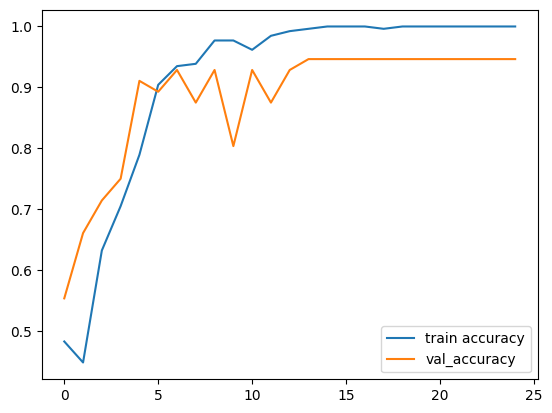

In [ ]:
plt.plot(model.history.history['accuracy'], label = 'train accuracy')
plt.plot(model.history.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
plt.show()

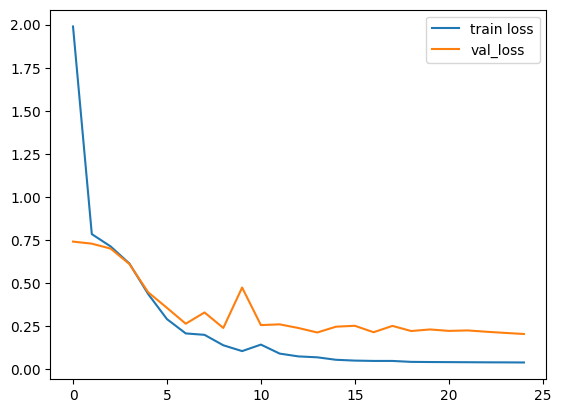

In [ ]:
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(X_test)

2/2 [==============================] - 1s 396ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

2/2 [==============================] - 1s 420ms/step - loss: 0.2996 - accuracy: 0.9464
Test loss: 0.299569308757782
Test accuracy: 0.9464285969734192
